# TAIL RISK FUND: OPTIONS (BHANSALI STRATEGY)

author: [@sparshsah](https://github.com/sparshsah)

ref: https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/tail-risk-fund_options.ipynb

In [1]:
from __future__ import annotations

import dataclasses
import datetime
from typing import Final, Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# https://github.com/sparshsah/foggy-statslib
import sys; sys.path.append("../../../foggy-statslib/")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

In [10]:
@dataclasses.dataclass(kw_only=True, frozen=True)
class StrategyConfig:
    """By default, buy puts on COF quarterly at 20% OTM, selling iff value hits 2x initial price."""
    start_date: datetime.datetime = datetime.datetime(2014, 7, 1)
    budget_dol: float = 100
    contract_kind: Literal["call", "put"] = "put"
    underlying_ticker: str = "COF"
    period_freq: Literal["M", "Q-DEC", "2Q-DEC", "Y-DEC"] = "Q-DEC"
    roll_buffer_days: int = 21  # look to roll this many trading days before expiration
    strike_otm_px: float = 0.20
    sell_thresh: float = 2.0
    impl_lag_days: int = 3  # trading lag in days

    @property
    def periods(self) -> pd.PeriodIndex:
        """Get the backtest periods."""
        return pd.period_range(
            start=self.start_date,
            end=datetime.datetime.now(),
            freq=self.period_freq,
            name="period",
        # first period is burn-in
        )[1:]

    @property
    def timeseries(self) -> pd.DataFrame:
        """Get the backtest periods, and associated data (e.g. entry/exit dates)."""
        ts = pd.DataFrame(index=self.periods)
        ts.loc[:, "entry_date"] = ts.index.start_time - self.roll_buffer_days * pd.offsets.BDay()
        ts.loc[:, "expiration_date"] = ts.index.end_time
        return ts

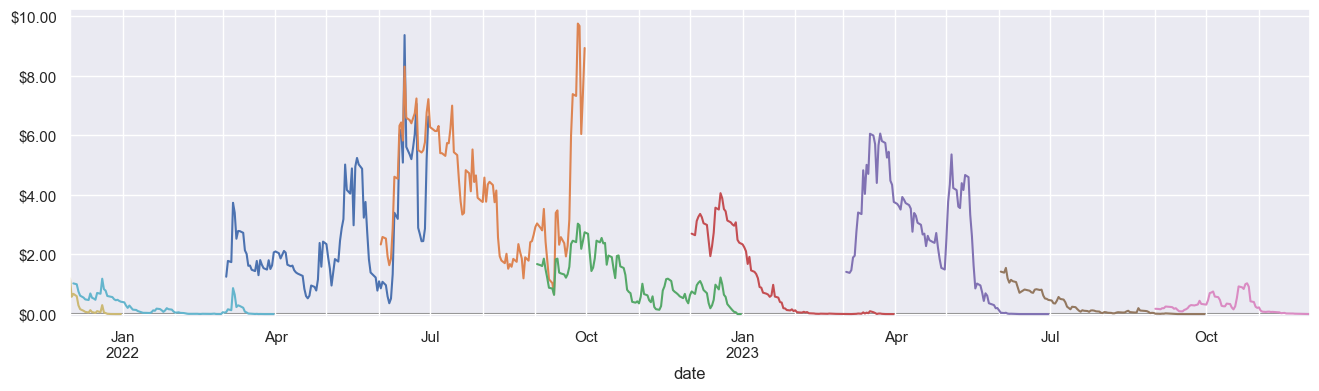

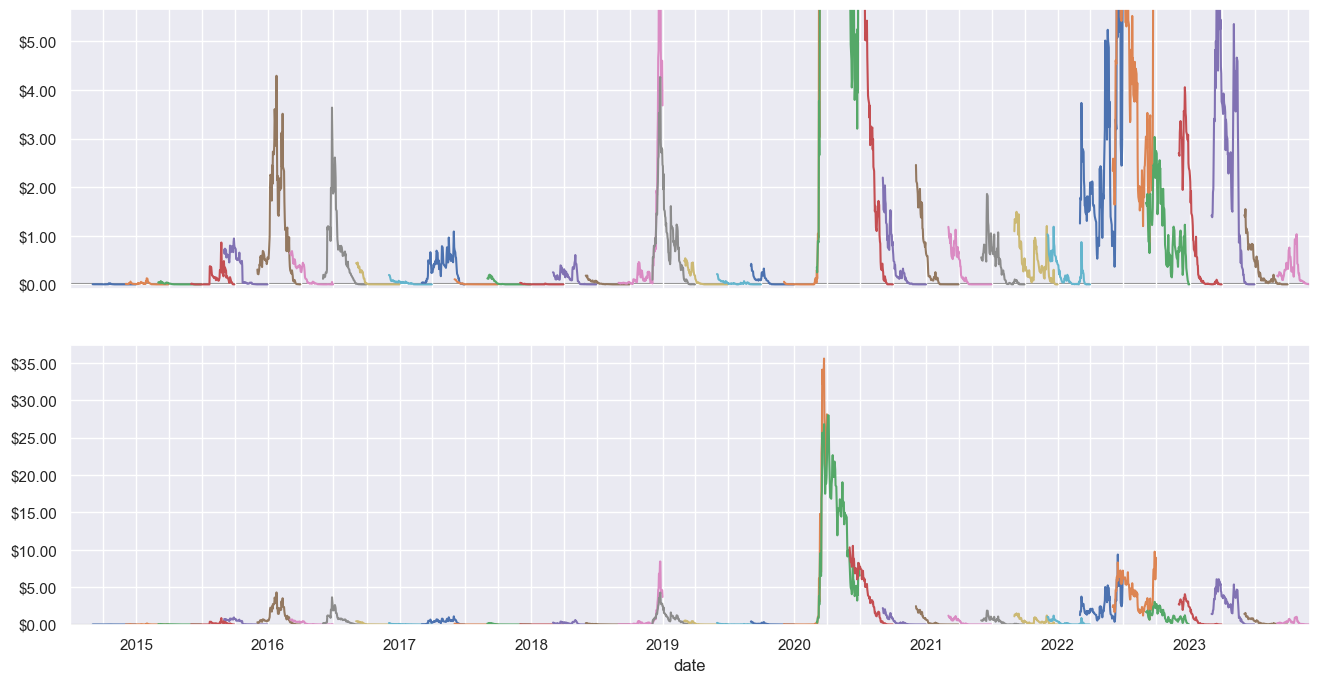

In [6]:
# DATA


class MarketDataAccess:
    """Module for getting data."""

    @staticmethod
    def _get_history(
        ticker: str,
        start_date: datetime.datetime,
        end_date: datetime.datetime,
    ) -> pd.DataFrame:
        ...

    @staticmethod
    def get_underlying_history(ticker: str = "COF") -> pd.DataFrame:
        """Indexed by date, Columns = [unadj_close_price_dol, vol]."""
        cfg = StrategyConfig()
        p = (
            pd.read_csv(
                f"data/yahoo-finance_NYSE-{ticker}_px.csv",
                index_col="Date",
                parse_dates=True,
            )
            .loc[cfg.start_date:, "Close"]
            .rename_axis("date").rename("unadj_close_price_dol")
            .asfreq("D").ffill()
        )
        p_b = p.asfreq("B")
        r_b = p_b / p_b.shift() - 1
        vol_b = fsf._brutishly_est_vol_of_r(xr=r_b)
        vol = vol_b.asfreq("D").ffill()
        history = pd.concat([p, vol], axis="columns", verify_integrity=True)
        return history

    @staticmethod
    def select_contract(
        contract_kind: str,
        underlying_ticker: str,
        entry_date: datetime.datetime,
        expiration_date: datetime.datetime,
        strike_price_dol: float,
    ) -> str:
        """Grab the ticker that best matches the desired contract."""
        cfg = StrategyConfig()
        period = pd.Period(expiration_date, freq=cfg.period_freq)
        # we generate only the data for these settings in `_generate_contract_histories()`
        _ = contract_kind, underlying_ticker, entry_date, strike_price_dol
        return str(period)

    @staticmethod
    def _generate_contract_histories() -> pd.DataFrame:
        """Manually Black-Scholes just the data points we need given the strategy we're trying to backtest."""
        cfg = StrategyConfig()
        ts = cfg.timeseries
        uh = MarketDataAccess.get_underlying_history(ticker=cfg.underlying_ticker)

        def _gen_cell(contract_ticker: str, t: pd.Timestamp) -> float:
            period = contract_ticker
            entry_date = ts.loc[period, "entry_date"]
            expiration_date = ts.loc[period, "expiration_date"]
            if entry_date <= t <= expiration_date:
                return fsf.calc_bsf_option_value(
                    # set at entry
                    put=cfg.contract_kind == "put",
                    K=uh.loc[entry_date, "unadj_close_price_dol"] * (1 - cfg.strike_otm_px),
                    # calculated today
                    tau=(expiration_date - t).days / 365,
                    S_t=uh.loc[t, "unadj_close_price_dol"],
                    sigma=uh.loc[t, "vol"],  # let's assume a 1.1x vol premium
                    # whatever
                    r=0.05,
                )
            else:
                return float("nan")

        ch = pd.DataFrame(
            columns=ts.index,
            index=pd.date_range(
                start=cfg.start_date,
                end=uh.last_valid_index(),
                freq="D",
                name="date",
            ),
            dtype=float,
        )
        ch = pd.DataFrame(
            {
                period: {
                    t: _gen_cell(contract_ticker=str(period), t=t)
                    for t in ch.index
                }
                for period in ch.columns
            },
            index=ch.index,
            columns=ch.columns,
        )
        return ch

    @staticmethod
    def get_contract_history(
        ticker: str,
        start_date: datetime.datetime,
        end_date: datetime.datetime,
    ) -> pd.Series[float]:
        """Timeseries of closing prices."""
        history = CONTRACT_HISTORIES.loc[start_date:end_date, ticker]
        # from generated data, this should be valid already
        assert start_date in history.index, (start_date, history.index[:8])
        assert end_date in history.index, (end_date, history.index[-8:])
        assert not history.isna().any(), history.isna().mean()
        # for IRL data, we might need to clean up
        dtx = pd.date_range(start=start_date, end=end_date, freq="D", name="date")
        history = history.reindex(index=dtx).ffill()
        return history


def init_data() -> tuple[pd.DataFrame, pd.DataFrame]:
    UNDERLYING_HISTORY = MarketDataAccess.get_underlying_history()
    CONTRACT_HISTORIES = MarketDataAccess._generate_contract_histories()
    fsc.plot(
        CONTRACT_HISTORIES.loc[
            CONTRACT_HISTORIES.index[-1] - 2*365*pd.offsets.Day():,
            :,
        ],
        ydollar=True,
        ylim_bottom=-0.10,
        legend=False,
        figsize=(16, 4),
    )
    _, ax = plt.subplots(nrows=2, sharex=True)
    fsc.plot(
        CONTRACT_HISTORIES,
        ydollar=True,
        ylim_top=CONTRACT_HISTORIES.quantile(0.90).quantile(0.90),
        ylim_bottom=-0.10,
        legend=False,
        ax=ax[0],
    )
    fsc.plot(
        CONTRACT_HISTORIES,
        ydollar=True,
        ylim_bottom=-0.10,
        legend=False,
        figsize=(16, 8),
        ax=ax[1],
    )
    plt.show()
    return UNDERLYING_HISTORY, CONTRACT_HISTORIES
UNDERLYING_HISTORY, CONTRACT_HISTORIES = init_data()

In [ ]:
# BACKTEST


cfg = StrategyConfig()
ts = cfg.timeseries

In [ ]:
backtest = 

In [ ]:
for cfg_row in ts.itertuples():
    ticker = 
    ph = MarketDataAccess.get_put_history(
        ticker=

In [7]:
%%timeit
for period, cfg_row in PUT_HISTORIES.iterrows():
    pass

NameError: name 'PUT_HISTORIES' is not defined